In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
(W1s, U1, W1o, B1s, B1o,
 W2s, U2, W2o, B2s, B2o,
 Wout, Bout) = np.load('weights.npz').values()

In [3]:
B1s = B1s.flatten()
B1o = B1o.flatten()
B2s = B2s.flatten()
B2o = B2o.flatten()
Bout = Bout.flatten()

In [4]:
def relu(v):
    v[v<=0]=0
    v[v>30]=30
    return v
def rnn_step(state, v_in, Ws, U, Bs, Wo, Bo):
    new_state = relu(Ws@state + U@v_in + Bs)
    v_out = relu(Wo@new_state+Bo)
    return new_state, v_out

In [5]:
def model_step(state1, state2, v_in):
    state1, v1 = rnn_step(state1, v_in, W1s, U1, B1s, W1o, B1o)
    state2, v2 = rnn_step(state2, v1  , W2s, U2, B2s, W2o, B2o)
    v_out = Wout@v2 + Bout
    v_out = np.exp(v_out)
    v_out /= np.sum(v_out)
    c = np.argmax(v_out)
    return state1, state2, v1, v2, v_out, c

In [6]:
recorded_input = np.loadtxt('log_test')[:,:6]

In [7]:
recorded_input.shape

(8451, 6)

In [8]:
output = []
state1 = np.zeros(6)
state2 = np.zeros(6)

for row in recorded_input:
    state1, state2, v1, v2, v_out, c = model_step(state1, state2, row)
    output.append((state1, state2, v1, v2, v_out, c))

In [9]:
classes = np.array([_[-1] for _ in output])

In [10]:
# some smoothing filters for purely easthetic reasons
g = np.linspace(-2,2,20)
g = np.exp(-g**2)
gs = np.sum(g)
def moving_average(x):
    return np.convolve(x, g, 'valid') / gs

In [11]:
starting_point = -14*50-30 # we are not going to print out the entire record
end_point = -4*50
classes_considered = moving_average(classes)[starting_point:end_point]
input_considered = recorded_input[starting_point:end_point]
outputs_considered = output[starting_point:end_point]

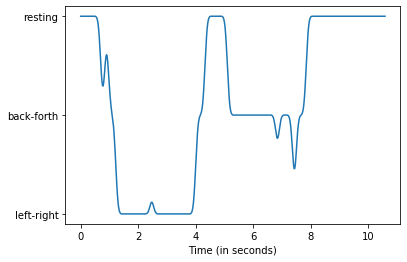

In [12]:
t = np.arange(len(classes_considered))*0.02
plt.plot(t,classes_considered)
plt.yticks([0,1,2],['left-right','back-forth','resting'])
plt.xlabel('Time (in seconds)')
plt.savefig('class_v_time.png',dpi=300)

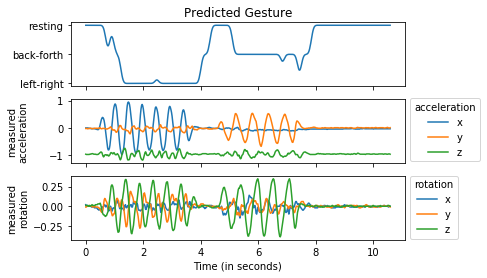

In [13]:
f,(a,b,c) = plt.subplots(3,1,sharex=True)
a.plot(t,classes_considered)
a.set_yticks([0,1,2])
a.set_yticklabels(['left-right','back-forth','resting'])
b.plot(t,input_considered[:,:3])
b.legend('xyz',title='acceleration',bbox_to_anchor=(1,1.095))
c.plot(t,input_considered[:,3:])
c.legend('xyz',title='rotation',bbox_to_anchor=(1,1.0825))
c.set_xlabel('Time (in seconds)')
a.set_title('Predicted Gesture')
b.set_ylabel('measured\nacceleration',labelpad=20)
c.set_ylabel('measured\nrotation')
f.savefig('class_and_input_v_time.png',dpi=300)

 529

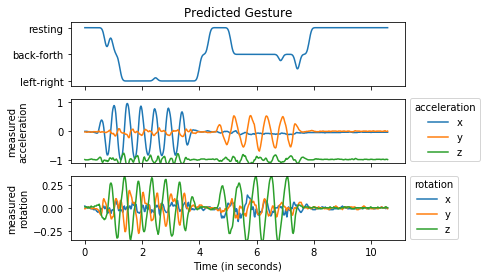

In [25]:
for _f in range(len(t)): # A particularly slow way to do it
    plt.close('all')
    print('\r',_f,end='',flush=True)
    frame = _f+1
    f,(a,b,c) = plt.subplots(3,1,sharex=True)
    a.set_xlim(-0.5,11.2)
    a.plot(t[:frame],classes_considered[:frame])
    a.set_yticks([0,1,2])
    a.set_yticklabels(['left-right','back-forth','resting'])
    b.plot(t[:frame],input_considered[:frame,:3])
    b.legend('xyz',title='acceleration',bbox_to_anchor=(1,1.095),loc=2)
    c.plot(t[:frame],input_considered[:frame,3:])
    c.legend('xyz',title='rotation',bbox_to_anchor=(1,1.0825),loc=2)
    c.set_xlabel('Time (in seconds)')
    a.set_title('Predicted Gesture')
    b.set_ylabel('measured\nacceleration',labelpad=20)
    c.set_ylabel('measured\nrotation')
    b.set_ylim(-1.1,1.1)
    c.set_ylim(-.35,.35)
    a.set_ylim(-0.2,2.2)
    f.savefig('plots/log_%s.png'%_f,dpi=300,bbox_inches='tight')

In [ ]:
# The coordinates at which to plot each neuron
ix = np.ones(6)
iy = np.arange(6)-2.5
s1x = np.ones(6)+1
s1y = np.arange(6)-2.5
v1x = np.ones(6)+2
v1y = np.arange(6)-2.5
s2x = np.ones(6)+3
s2y = np.arange(6)-2.5
v2x = np.ones(6)+4
v2y = np.arange(6)-2.5
vox = np.ones(3)+5
voy = np.arange(3)-1

In [ ]:
# The lines representing each synapse
lines = []
widths = []
y_coords = [iy,s1y,v1y,s2y,v2y,voy]
matrices = [U1,W1o,U2,W2o,Wout]
for var_i, var in enumerate(matrices):
    jj,ii = var.shape
    for i in range(ii):
        for j in range(jj):
            mag = np.abs(var[j,i])
            if mag<0.2:
                continue
            lines.append([(var_i+1,y_coords[var_i][i]),(var_i+2,y_coords[var_i+1][j])])
            widths.append(mag)

In [ ]:
# A histogram of the weights in the neural network
plt.hist(np.abs(np.concatenate([_.flatten() for _ in matrices])))

In [ ]:
for frame, out in enumerate(outputs_considered): # A particularly slow way to do it
    plt.close('all')
    print('\r',frame,end='',flush=True)
    (state1, state2, v1, v2, v_out, c) = out
    row = input_considered[frame,:]

    f,a = plt.subplots(1,1)

    a.scatter(ix,iy,s=np.abs(row)*100)
    a.scatter(s1x,s1y,s=np.abs(state1)*100)
    a.scatter(v1x,v1y,s=np.abs(v1)*100)
    a.scatter(s2x,s2y,s=np.abs(state2)*100)
    a.scatter(v2x,v2y,s=np.abs(v2)*100)
    a.scatter(vox,voy,s=np.abs(v_out)*100)
    a.set_xlim(0.5,6.5)
    a.set_ylim(-3,3)
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.set_yticks(iy)
    a.set_yticklabels(['acc x','acc y', 'acc z', 'rot x', 'rot y', 'rot z'])
    a.set_ylabel('recorded motion')
    a.set_xticks([1,2,3,4,5,6])
    a.set_xticklabels(['$v_{in}$','$s_{1}$','$v_{rec1}$','$s_{2}$','$v_{rec2}$','$v_{out}$'],
                      fontdict={'fontsize':'larger'})
    line_collection = mpl.collections.LineCollection(lines,widths,zorder=-10,alpha=0.1,color='black')
    a.add_collection(line_collection)
    aright = a.twinx()
    aright.set_ylim(-3,3)
    aright.set_yticks(voy)
    aright.set_yticklabels(['left-right','back-forth','resting'])
    aright.spines['right'].set_visible(False)
    aright.spines['top'].set_visible(False)
    aright.spines['left'].set_visible(False)
    aright.spines['bottom'].set_visible(False)
    aright.set_ylabel('predicted gesture')
    f.savefig('plots/net_%s.png'%frame,dpi=300,bbox_inches='tight')
    None